In [1]:
import pandas as pd
import numpy as np
from graphviz import Digraph

def randomDataSet(num_samples, num_positive_percentage):
    #Generate random dataset with 5 numerical features and 5 categorical features, containing missing values in all features also
    # Generating numerical features
    num_features = pd.DataFrame({
        'num_feature1': np.random.randn(num_samples) * 100,
        'num_feature2': np.random.uniform(0, 100, num_samples),
        'num_feature3': np.random.randint(0, 1000, num_samples),
        'num_feature4': np.random.normal(50, 10, num_samples),
        'num_feature5': np.random.gamma(2, 1.5, num_samples),
    })

    # Generating categorical features
    cat_features = pd.DataFrame({
        'cat_feature1': np.random.choice(['A', 'B', 'C', 'D'], num_samples),
        'cat_feature2': np.random.choice(['Yes', 'No'], num_samples),
        'cat_feature3': np.random.choice(['Low', 'Medium', 'High'], num_samples),
        'cat_feature4': np.random.choice(['Red', 'Blue', 'Green', 'Yellow'], num_samples),
        'cat_feature5': np.random.choice(['Type1', 'Type2', 'Type3'], num_samples),
    })

    # Combine numerical and categorical features into one DataFrame
    dataset = pd.concat([num_features, cat_features], axis=1)
    target = np.zeros(num_samples)
    num_positive = int(num_positive_percentage * num_samples)
    positive_indices = np.random.choice(dataset.index, num_positive, replace=False)
    target[positive_indices] = 1
    #target = np.random.choice([0, 1], num_samples)

    # Add the target variable to the dataset
    dataset['target'] = target
    # Introduce NaN values with varying percentages in each feature
    nan_percentages = {
        'num_feature1': 0.05,  # 5% missing values
        'num_feature2': 0.1,   # 10% missing values
        'num_feature3': 0.15,  # 15% missing values
        'num_feature4': 0.2,   # 20% missing values
        'num_feature5': 0.25,  # 25% missing values
        'cat_feature1': 0.05,  # 5% missing values
        'cat_feature2': 0.1,   # 10% missing values
        'cat_feature3': 0.15,  # 15% missing values
        'cat_feature4': 0.2,   # 20% missing values
        'cat_feature5': 0.25,  # 25% missing values
    }

    # Apply NaN values to the dataset based on the specified percentages
    for column, nan_percentage in nan_percentages.items():
        nan_count = int(num_samples * nan_percentage)
        nan_indices = np.random.choice(dataset.index, nan_count, replace=False)
        dataset.loc[nan_indices, column] = np.nan
    # Display the first few rows of the dataset with the target variable
    # Display the first few rows of the dataset
    return dataset

def calculate_gini(input_class_list):
    """Calculate Gini impurity for a list of classes."""
    x_series = pd.Series(input_class_list)
    value_counts = x_series.value_counts(normalize=True)
    impurity = value_counts.apply(lambda x: x * (1 - x)).sum()
    return impurity

def can_convert_to_numeric(df, column_name):
    """Check if a column of dtype object can be converted to numeric."""
    if df[column_name].dtype == 'object':
        converted = pd.to_numeric(df[column_name], errors='coerce')
        return converted.notna().all()
    return True

def calculate_information_gain(df, feature, target, cutoff, is_numeric):
    """Calculate information gain for a given cutoff in a feature."""
    df[feature] = df[feature].fillna(0)
    total_size = len(df)
    initial_gini = calculate_gini(df[target])

    if is_numeric:
        df1 = df[df[feature] <= cutoff]
        df2 = df[df[feature] > cutoff]
    else:
        df1 = df[df[feature] == cutoff]
        df2 = df[df[feature] != cutoff]

    gini_df1 = calculate_gini(df1[target])
    gini_df2 = calculate_gini(df2[target])
    information_gain = initial_gini - (len(df1) * gini_df1 + len(df2) * gini_df2) / total_size

    return information_gain

def find_best_cutoff(df, feature, target, num_segments=None):
    """Find the best cutoff value for a feature that maximizes information gain."""
    best_info_gain = -np.inf
    best_cutoff = None
    
    df[feature] = df[feature].fillna(0)
    
    if num_segments:
        bin_edges = pd.cut(df[feature], bins=num_segments, retbins=True, labels=False)[1]
        segmentation_points = bin_edges[1:-1]
    else:
        segmentation_points = sorted(df[feature].unique())
    
    for cutoff in segmentation_points:
        info_gain = calculate_information_gain(df, feature, target, cutoff, can_convert_to_numeric(df, feature))
        if info_gain > best_info_gain:
            best_info_gain = info_gain
            best_cutoff = cutoff

    return best_cutoff, best_info_gain

def find_best_cutoff_for_feature(df, feature, target, num_segments, max_unique_values):
    """Determine the best cutoff value for a feature, considering if it's numeric or categorical."""
    is_numeric = can_convert_to_numeric(df, feature)
    df[feature] = pd.to_numeric(df[feature], errors='coerce') if is_numeric else df[feature].fillna('missing')

    unique_values = df[feature].nunique()
    
    num_segments = None if unique_values < max_unique_values or not is_numeric else num_segments

    best_cutoff, best_info_gain = find_best_cutoff(df, feature, target, num_segments)
    
    return best_cutoff, best_info_gain, is_numeric

def build_decision_tree(df, target):
    """Build a single-level decision tree based on the feature that provides the best information gain."""
    num_segments = 20
    max_unique_values = 100
    features = [col for col in df.columns if col != target]
    
    best_feature = None
    best_cutoff = None
    best_info_gain = -np.inf
    colIG = pd.DataFrame()
    colIG['feature'] = features
    colIG['bestCutOff'] = 'NA'
    colIG['bestIG'] = 0
    for i, feature in enumerate(features):
        print(f'Spliting point for {feature}...')
        cutoff, info_gain, is_numeric = find_best_cutoff_for_feature(df, feature, target, num_segments, max_unique_values)
        print(f'Numeric type: {is_numeric}')
        #colIG['bestCutOff'].iloc[i] = cutoff
        #colIG['bestIG'].iloc[i] = info_gain
        if info_gain > best_info_gain:
            best_info_gain = info_gain
            best_feature = feature
            best_cutoff = cutoff
    print(best_feature + ':' + str(best_cutoff))
    return best_feature, best_cutoff, best_info_gain, colIG, is_numeric
def build_full_tree(df, targetName, max_depth, parentLeave):
    print('Parrent: ', parentLeave)
    features = [col for col in df.columns if col != targetName]
    print('Number of remained column: ', len(features))
    print('Depth: ', max_depth)
    if len(features) > 0:
        best_feature, best_cutoff, best_info_gain, colIG, is_numeric = build_decision_tree(df, targetName)
    if (len(features) == 1) or (max_depth == 1):
        return '(' + parentLeave  + '-LL-'+ best_feature + ':' + str(best_cutoff) + ')'
    else:
        if(can_convert_to_numeric(df, best_feature)):
            df_left = df[df[best_feature] <= best_cutoff]
            df_right = df[df[best_feature] > best_cutoff]
        else:
            df_left = df[df[best_feature] == best_cutoff]
            df_right = df[df[best_feature] != best_cutoff]
        df_left = df_left.drop(columns = best_feature)
        df_right = df_right.drop(columns = best_feature)
        nodeName = best_feature + ':' + str(best_cutoff) + ';'

        return   build_full_tree(df_left, targetName, max_depth - 1, '(' + parentLeave +   best_feature + '-L-' + ')' ) +  build_full_tree(df_right, targetName, max_depth - 1, '(' + parentLeave +  best_feature + '-R-' + ')' )
def calculate_leaf_label(df, target_name):
    is_numeric = can_convert_to_numeric(df, target_name)
    class_counts_str = ', '.join([f'{index}-> {count}' for index, count in df[target_name].value_counts().items()])
    if is_numeric:
        modeData = df[target_name].value_counts(normalize=True)
        print(modeData)
        return str(modeData.index[0]) + ':'+ str(modeData.iloc[0]) +':' + class_counts_str
    else:
        modeData = df[target_name].value_counts(normalize=True)
        return str(modeData.index[0]) + ':'+ str(modeData.iloc[0])+ ':' + class_counts_str

def build_full_tree_refactor(df, target_name, max_depth, parent_label):
    #Refactor version with help of ChatGPT
    features = [col for col in df.columns if col != target_name]
    if len(features) > 0:
        best_feature, best_cutoff, best_info_gain, colIG, is_numeric = build_decision_tree(df, target_name)
        is_numeric = can_convert_to_numeric(df, best_feature)
        nodeSymbol =  '<=' if is_numeric== True else '='
        print(f'Best feature {best_feature}, Numeric: {is_numeric}, Node symbol :{nodeSymbol}')
    if not features or max_depth == 0:
        #return {'label': f'{best_feature}{nodeSymbol}{best_cutoff}', 'leaf': True}
        leaf_label = calculate_leaf_label(df, target_name)
        return {'label': f'{leaf_label}', 'leaf': True}
    if can_convert_to_numeric(df, best_feature):
        df_left = df[df[best_feature] <= best_cutoff]
        df_right = df[df[best_feature] > best_cutoff]
    else:
        df_left = df[df[best_feature] == best_cutoff]
        df_right = df[df[best_feature] != best_cutoff]

    #df_left = df_left.drop(columns=best_feature)
    #df_right = df_right.drop(columns=best_feature)

    node = {
        'label': f'{best_feature}{nodeSymbol}{best_cutoff}',
        'left': build_full_tree_refactor(df_left, target_name, max_depth - 1, f'L-{best_feature}'),
        'right': build_full_tree_refactor(df_right, target_name, max_depth - 1, f'R-{best_feature}')
    }

    return node

def visualize_tree(tree_structure, parent_name='', graph=None, node_id=0):
    """Code by Chat GPT"""
    if graph is None:
        graph = Digraph()
        graph.attr('node', shape='circle')
    
    # Assign a unique name for each node
    node_name = f'node{node_id}'
    
    # Add the current node to the graph
    label = tree_structure['label']
    graph.node(node_name, label)
    
    if parent_name:
        graph.edge(parent_name, node_name)
    
    # Recursively add child nodes
    if 'left' in tree_structure:
        graph = visualize_tree(tree_structure['left'], node_name, graph, node_id=node_id*2+1)
    if 'right' in tree_structure:
        graph = visualize_tree(tree_structure['right'], node_name, graph, node_id=node_id*2+2)
    
    return graph    

def evaluate_tree(tree, observation):
    """Code with help ChatGPT 4.0"""
    # If the current node is a leaf, return the label
    if tree.get('leaf', False):
        return tree['label']
    
    # Parse the current node's label to extract feature and threshold
    node_label = tree['label']
    
    if "<=" in node_label:
        feature, threshold = node_label.split("<=")
        threshold = float(threshold)
        
        if observation[feature.strip()] <= threshold:
            return evaluate_tree(tree['left'], observation)
        else:
            return evaluate_tree(tree['right'], observation)
    
    elif "=" in node_label:
        feature, value = node_label.split("=")
        
        if observation[feature.strip()] == value.strip():
            return evaluate_tree(tree['left'], observation)
        else:
            return evaluate_tree(tree['right'], observation)
    
    else:
        raise ValueError(f"Unsupported node label format: {node_label}")
    
dataset = randomDataSet(100000, 0.1)
target_name = 'target'

In [14]:
str(dataset.target.value_counts())
print(dataset.target.value_counts().items())
class_counts_str = ', '.join([f'{index}: {count}' for index, count in dataset.target.value_counts().items()])
print(class_counts_str)

0.0: 90000, 1.0: 10000


In [2]:
# Example to build a decision tree and visualize the tree 

tree_structure = build_full_tree_refactor(dataset, target_name, max_depth=3, parent_label='root')
print(tree_structure)
graph = visualize_tree(tree_structure)
graph.render('decision_tree', format='png', cleanup=True)
graph.view()
dataset['Predicted'] = dataset.apply(lambda row: evaluate_tree(tree_structure, row), axis=1)


Spliting point for num_feature1...
Numeric type: True
Spliting point for num_feature2...
Numeric type: True
Spliting point for num_feature3...
Numeric type: True
Spliting point for num_feature4...
Numeric type: True
Spliting point for num_feature5...
Numeric type: True
Spliting point for cat_feature1...
Numeric type: False
Spliting point for cat_feature2...
Numeric type: False
Spliting point for cat_feature3...
Numeric type: False
Spliting point for cat_feature4...
Numeric type: False
Spliting point for cat_feature5...
Numeric type: False
cat_feature5:missing
Best feature cat_feature5, Numeric: False, Node symbol :=
Spliting point for num_feature1...
Numeric type: True
Spliting point for num_feature2...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = pd.to_numeric(df[feature], errors='coerce') if is_numeric else df[feature].fillna('missing')
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set o

Numeric type: True
Spliting point for num_feature3...
Numeric type: True
Spliting point for num_feature4...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Numeric type: True
Spliting point for num_feature5...
Numeric type: True
Spliting point for cat_feature1...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Numeric type: False
Spliting point for cat_feature2...
Numeric type: False
Spliting point for cat_feature3...
Numeric type: False
Spliting point for cat_feature4...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = pd.to_numeric(df[feature], errors='coerce') if is_numeric else df[feature].fillna('missing')
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set o

Numeric type: False
Spliting point for cat_feature5...
Numeric type: False
cat_feature3:missing
Best feature cat_feature3, Numeric: False, Node symbol :=
Spliting point for num_feature1...
Numeric type: True
Spliting point for num_feature2...
Numeric type: True
Spliting point for num_feature3...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = pd.to_numeric(df[feature], errors='coerce') if is_numeric else df[feature].fillna('missing')
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set o

Numeric type: True
Spliting point for num_feature4...
Numeric type: True
Spliting point for num_feature5...
Numeric type: True
Spliting point for cat_feature1...
Numeric type: False
Spliting point for cat_feature2...
Numeric type: False
Spliting point for cat_feature3...
Numeric type: False
Spliting point for cat_feature4...
Numeric type: False
Spliting point for cat_feature5...
Numeric type: False
num_feature1:-331.0044886609141
Best feature num_feature1, Numeric: True, Node symbol :<=


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Spliting point for num_feature1...
Numeric type: True
Spliting point for num_feature2...
Numeric type: True
Spliting point for num_feature3...
Numeric type: True
Spliting point for num_feature4...
Numeric type: True
Spliting point for num_feature5...
Numeric type: True
Spliting point for cat_feature1...
Numeric type: False
Spliting point for cat_feature2...
Numeric type: False
Spliting point for cat_feature3...
Numeric type: False
Spliting point for cat_feature4...
Numeric type: False
Spliting point for cat_feature5...
Numeric type: False
num_feature1:-369.1256119219197
Best feature num_feature1, Numeric: True, Node symbol :<=
1.0    1.0
Name: target, dtype: float64
Spliting point for num_feature1...
Numeric type: True
Spliting point for num_feature2...
Numeric type: True
Spliting point for num_feature3...
Numeric type: True
Spliting point for num_feature4...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Numeric type: True
Spliting point for num_feature5...
Numeric type: True
Spliting point for cat_feature1...
Numeric type: False
Spliting point for cat_feature2...
Numeric type: False
Spliting point for cat_feature3...
Numeric type: False
Spliting point for cat_feature4...
Numeric type: False
Spliting point for cat_feature5...
Numeric type: False
num_feature5:4.455772824012766
Best feature num_feature5, Numeric: True, Node symbol :<=
0.0    0.913798
1.0    0.086202
Name: target, dtype: float64
Spliting point for num_feature1...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Numeric type: True
Spliting point for num_feature2...
Numeric type: True
Spliting point for num_feature3...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = pd.to_numeric(df[feature], errors='coerce') if is_numeric else df[feature].fillna('missing')
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:96: SettingWithCopyWarning: 
A value is trying to be set o

Numeric type: True
Spliting point for num_feature4...
Numeric type: True
Spliting point for num_feature5...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Numeric type: True
Spliting point for cat_feature1...
Numeric type: False
Spliting point for cat_feature2...
Numeric type: False
Spliting point for cat_feature3...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Numeric type: False
Spliting point for cat_feature4...
Numeric type: False
Spliting point for cat_feature5...
Numeric type: False
num_feature3:49.95
Best feature num_feature3, Numeric: True, Node symbol :<=
Spliting point for num_feature1...
Numeric type: True
Spliting point for num_feature2...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

Numeric type: True
Spliting point for num_feature3...
Numeric type: True
Spliting point for num_feature4...
Numeric type: True
Spliting point for num_feature5...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Numeric type: True
Spliting point for cat_feature1...
Numeric type: False
Spliting point for cat_feature2...
Numeric type: False
Spliting point for cat_feature3...
Numeric type: False
Spliting point for cat_feature4...
Numeric type: False
Spliting point for cat_feature5...
Numeric type: False
cat_feature1:B
Best feature cat_feature1, Numeric: False, Node symbol :=
0.0    0.893706
1.0    0.106294
Name: target, dtype: float64
Spliting point for num_feature1...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = pd.to_numeric(df[feature], errors='coerce') if is_numeric else df[feature].fillna('missing')
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set o

Numeric type: True
Spliting point for num_feature2...
Numeric type: True
Spliting point for num_feature3...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Numeric type: True
Spliting point for num_feature4...
Numeric type: True
Spliting point for num_feature5...
Numeric type: True
Spliting point for cat_feature1...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

Numeric type: False
Spliting point for cat_feature2...
Numeric type: False
Spliting point for cat_feature3...
Numeric type: False
Spliting point for cat_feature4...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

Numeric type: False
Spliting point for cat_feature5...
Numeric type: False
cat_feature4:Red
Best feature cat_feature4, Numeric: False, Node symbol :=
0.0    0.903838
1.0    0.096162
Name: target, dtype: float64
Spliting point for num_feature1...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Numeric type: True
Spliting point for num_feature2...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Numeric type: True
Spliting point for num_feature3...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Numeric type: True
Spliting point for num_feature4...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Numeric type: True
Spliting point for num_feature5...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Numeric type: True
Spliting point for cat_feature1...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

Numeric type: False
Spliting point for cat_feature2...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

Numeric type: False
Spliting point for cat_feature3...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Numeric type: False
Spliting point for cat_feature4...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = pd.to_numeric(df[feature], errors='coerce') if is_numeric else df[feature].fillna('missing')
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set o

Numeric type: False
Spliting point for cat_feature5...
Numeric type: False
num_feature4:40.73314708525105
Best feature num_feature4, Numeric: True, Node symbol :<=


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

Spliting point for num_feature1...
Numeric type: True
Spliting point for num_feature2...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Numeric type: True
Spliting point for num_feature3...
Numeric type: True
Spliting point for num_feature4...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Numeric type: True
Spliting point for num_feature5...
Numeric type: True
Spliting point for cat_feature1...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Numeric type: False
Spliting point for cat_feature2...
Numeric type: False
Spliting point for cat_feature3...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Numeric type: False
Spliting point for cat_feature4...
Numeric type: False
Spliting point for cat_feature5...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

Numeric type: False
num_feature1:-183.34075125454925
Best feature num_feature1, Numeric: True, Node symbol :<=
Spliting point for num_feature1...
Numeric type: True
Spliting point for num_feature2...
Numeric type: True
Spliting point for num_feature3...
Numeric type: True
Spliting point for num_feature4...
Numeric type: True
Spliting point for num_feature5...
Numeric type: True
Spliting point for cat_feature1...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Numeric type: False
Spliting point for cat_feature2...
Numeric type: False
Spliting point for cat_feature3...
Numeric type: False
Spliting point for cat_feature4...
Numeric type: False
Spliting point for cat_feature5...
Numeric type: False
num_feature4:36.65373228562359
Best feature num_feature4, Numeric: True, Node symbol :<=
0.0    0.922983
1.0    0.077017
Name: target, dtype: float64
Spliting point for num_feature1...
Numeric type: True
Spliting point for num_feature2...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Numeric type: True
Spliting point for num_feature3...
Numeric type: True
Spliting point for num_feature4...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Numeric type: True
Spliting point for num_feature5...
Numeric type: True
Spliting point for cat_feature1...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Numeric type: False
Spliting point for cat_feature2...
Numeric type: False
Spliting point for cat_feature3...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = pd.to_numeric(df[feature], errors='coerce') if is_numeric else df[feature].fillna('missing')
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set o

Numeric type: False
Spliting point for cat_feature4...
Numeric type: False
Spliting point for cat_feature5...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = pd.to_numeric(df[feature], errors='coerce') if is_numeric else df[feature].fillna('missing')
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set o

Numeric type: False
num_feature2:84.9988905975354
Best feature num_feature2, Numeric: True, Node symbol :<=
0.0    0.893909
1.0    0.106091
Name: target, dtype: float64
Spliting point for num_feature1...
Numeric type: True
Spliting point for num_feature2...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Numeric type: True
Spliting point for num_feature3...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Numeric type: True
Spliting point for num_feature4...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Numeric type: True
Spliting point for num_feature5...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Numeric type: True
Spliting point for cat_feature1...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Numeric type: False
Spliting point for cat_feature2...
Numeric type: False
Spliting point for cat_feature3...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Numeric type: False
Spliting point for cat_feature4...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Numeric type: False
Spliting point for cat_feature5...
Numeric type: False
num_feature3:549.45
Best feature num_feature3, Numeric: True, Node symbol :<=
Spliting point for num_feature1...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

Numeric type: True
Spliting point for num_feature2...
Numeric type: True
Spliting point for num_feature3...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

Numeric type: True
Spliting point for num_feature4...
Numeric type: True
Spliting point for num_feature5...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = pd.to_numeric(df[feature], errors='coerce') if is_numeric else df[feature].fillna('missing')
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set o

Numeric type: True
Spliting point for cat_feature1...
Numeric type: False
Spliting point for cat_feature2...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Numeric type: False
Spliting point for cat_feature3...
Numeric type: False
Spliting point for cat_feature4...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = pd.to_numeric(df[feature], errors='coerce') if is_numeric else df[feature].fillna('missing')
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set o

Numeric type: False
Spliting point for cat_feature5...
Numeric type: False
cat_feature3:missing
Best feature cat_feature3, Numeric: False, Node symbol :=
0.0    0.90314
1.0    0.09686
Name: target, dtype: float64
Spliting point for num_feature1...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = pd.to_numeric(df[feature], errors='coerce') if is_numeric else df[feature].fillna('missing')
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set o

Numeric type: True
Spliting point for num_feature2...
Numeric type: True
Spliting point for num_feature3...
Numeric type: True
Spliting point for num_feature4...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Numeric type: True
Spliting point for num_feature5...
Numeric type: True
Spliting point for cat_feature1...
Numeric type: False
Spliting point for cat_feature2...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Numeric type: False
Spliting point for cat_feature3...
Numeric type: False
Spliting point for cat_feature4...
Numeric type: False
Spliting point for cat_feature5...


C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna(0)
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = pd.to_numeric(df[feature], errors='coerce') if is_numeric else df[feature].fillna('missing')
C:\Users\Thomas Thuy\AppData\Local\Temp\ipykernel_33340\1692218391.py:96: SettingWithCopyWarning: 
A value is trying to be set o

Numeric type: False
cat_feature4:Blue
Best feature cat_feature4, Numeric: False, Node symbol :=
0.0    0.897121
1.0    0.102879
Name: target, dtype: float64
{'label': 'cat_feature5=missing', 'left': {'label': 'cat_feature3=missing', 'left': {'label': 'num_feature1<=-331.0044886609141', 'left': {'label': '1.0:1.0:1.0-> 1', 'leaf': True}, 'right': {'label': '0.0:0.9137977048305311:0.0-> 3424, 1.0-> 323', 'leaf': True}}, 'right': {'label': 'num_feature3<=49.95', 'left': {'label': '0.0:0.8937056086211119:0.0-> 3649, 1.0-> 434', 'leaf': True}, 'right': {'label': '0.0:0.9038383132389772:0.0-> 15518, 1.0-> 1651', 'leaf': True}}}, 'right': {'label': 'num_feature4<=40.73314708525105', 'left': {'label': 'num_feature1<=-183.34075125454925', 'left': {'label': '0.0:0.9229828850855746:0.0-> 755, 1.0-> 63', 'leaf': True}, 'right': {'label': '0.0:0.8939094683381031:0.0-> 22177, 1.0-> 2632', 'leaf': True}}, 'right': {'label': 'num_feature3<=549.45', 'left': {'label': '0.0:0.9031400728418152:0.0-> 27525

In [18]:
dataset

,num_feature1,num_feature2,num_feature3,num_feature4,num_feature5,cat_feature1,cat_feature2,cat_feature3,cat_feature4,cat_feature5,target,Predicted
0,36.032652,0.000000,662.0,59.428388,4.626697,C,No,Low,missing,missing,0.0,"0.0:0.8966039606687416:0.0-> 32553, 1.0-> 3754"
1,-22.180652,74.887001,580.0,51.631671,4.905451,C,Yes,High,Blue,Type3,0.0,"0.0:0.9007973048848962:0.0-> 40108, 1.0-> 4417"
2,-144.874109,73.264223,0.0,0.000000,0.973322,A,missing,High,Yellow,missing,0.0,"0.0:0.8878326996197718:0.0-> 934, 1.0-> 118"
3,15.282450,37.578672,823.0,39.508610,3.272508,C,No,High,missing,Type2,0.0,"0.0:0.8966039606687416:0.0-> 32553, 1.0-> 3754"
4,-66.356179,92.212492,0.0,0.000000,1.806342,D,Yes,Low,Green,Type3,1.0,"0.0:0.9091251317572655:0.0-> 12075, 1.0-> 1207"
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-10.935228,69.286203,847.0,37.434365,0.000000,B,Yes,Medium,missing,missing,0.0,"0.0:0.9007973048848962:0.0-> 40108, 1.0-> 4417"
99996,149.790046,51.916104,34.0,70.760524,1.479555,C,No,Medium,Blue,Type3,0.0,"0.0:0.9091251317572655:0.0-> 12075, 1.0-> 1207"
99997,72.214648,83.772401,642.0,53.791926,0.000000,B,Yes,Medium,Red,Type1,0.0,"0.0:0.9007973048848962:0.0-> 40108, 1.0-> 4417"
99998,32.873941,91.378314,464.0,54.614860,4.438071,A,No,High,Blue,missing,0.0,"0.0:0.8966039606687416:0.0-> 32553, 1.0-> 3754"


In [3]:
import sklearn.model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

dataset = dataset.drop(columns=['Predicted'])
dataset_encoded = pd.get_dummies(dataset, columns=['cat_feature1','cat_feature2','cat_feature3','cat_feature4','cat_feature5'])

#X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dataset.drop(columns =target_name), dataset[target_name], test_size=0.25, random_state=42)
X_train = dataset_encoded.drop(columns =target_name)
y_train = dataset_encoded[target_name]
# Initialize the Decision Tree classifier
clf = DecisionTreeClassifier(random_state=42, max_depth=3)

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = clf.predict(X_train)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_train, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print a detailed classification report
print(classification_report(y_train, y_pred))

# If you want to see the predicted probabilities:
y_proba = clf.predict_proba(X_train)
print("Predicted probabilities:\n", y_proba)

Accuracy: 0.90
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95     90000
         1.0       0.80      0.00      0.00     10000

    accuracy                           0.90    100000
   macro avg       0.85      0.50      0.47    100000
weighted avg       0.89      0.90      0.85    100000

Predicted probabilities:
 [[0.90128928 0.09871072]
 [0.90128928 0.09871072]
 [0.90128928 0.09871072]
 ...
 [0.89649015 0.10350985]
 [0.89649015 0.10350985]
 [0.89649015 0.10350985]]


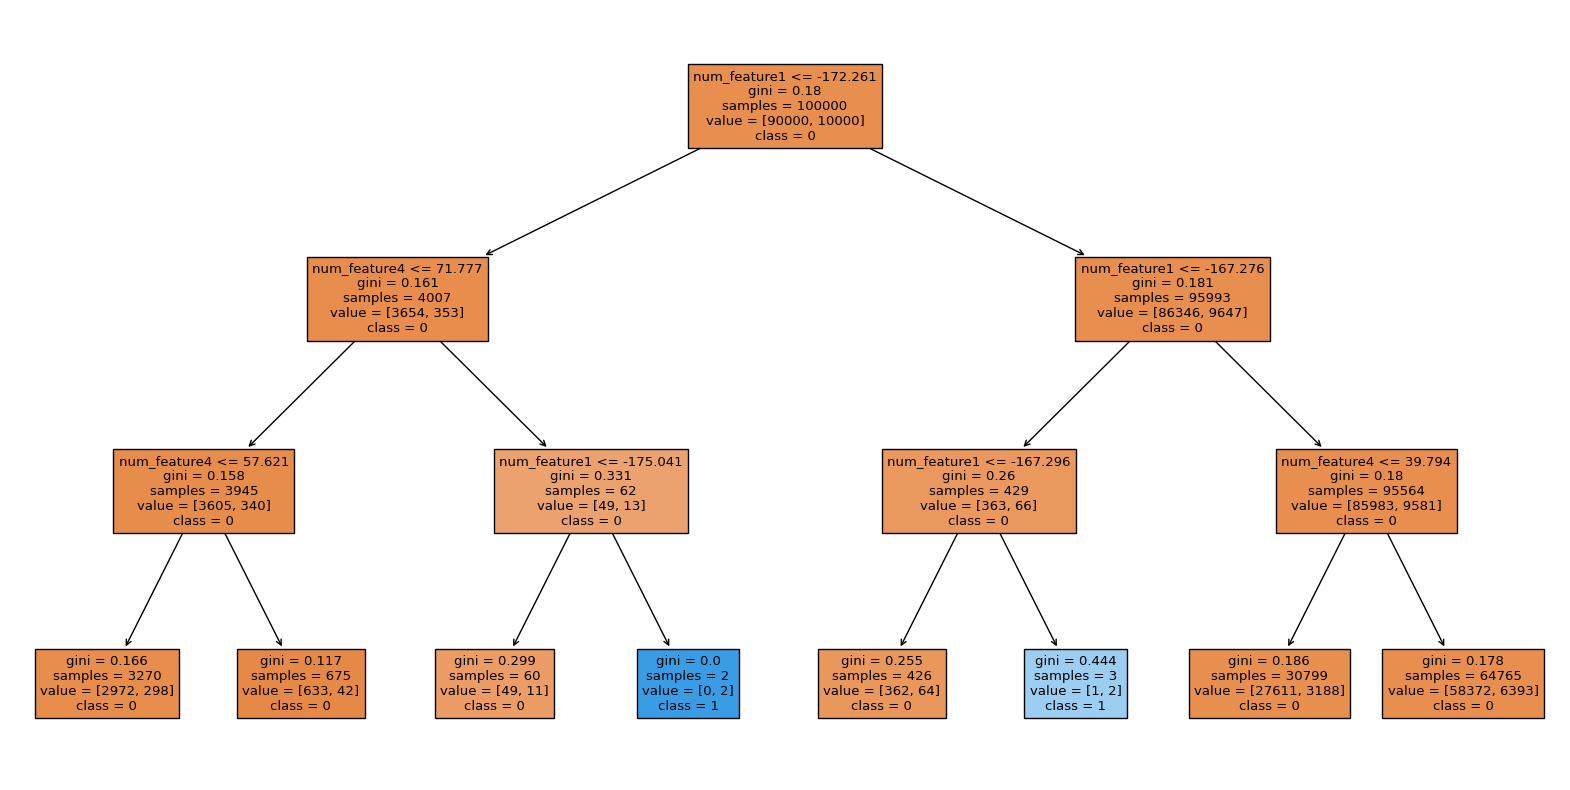

In [4]:
# Visualize the Decision Tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))  # Adjust the size of the plot
sklearn.tree.plot_tree(clf, feature_names=dataset_encoded.columns, class_names=['0', '1'], filled=True)
plt.show()